In [267]:
import numpy as np
import math
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import jpholiday
from sklearn.preprocessing import LabelEncoder
from ydata_profiling import ProfileReport

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 300

%matplotlib inline

In [268]:
train = pd.read_csv('./given_files/train.csv', encoding='utf-8')
search_specified = pd.read_csv('./given_files/search_specified.csv', encoding='utf-8')
search_unspecified = pd.read_csv('./given_files/search_unspecified.csv', encoding='utf-8')
road = pd.read_csv('./given_files/road_local.csv', encoding='utf-8')

In [269]:
# day_of_week, day_of_year, holiday, tomorrow_holiday, yesterday_holidayを追加
def is_holiday(date):
    
    return (date.weekday() >= 5) or jpholiday.is_holiday(date)


def set_flags(df):
    
    df['tomorrow'] = df['date'] + pd.to_timedelta(1, 'd')
    df['day_of_week'] = df['date'].dt.weekday
    
    holidays = df['date'].apply(jpholiday.is_holiday)

    df['holiday'] = ((df['day_of_week'] >= 5) | holidays).astype(int)
    df['tomorrow_holiday'] = ((df['tomorrow'].dt.weekday >= 5) | holidays.shift(-1)).astype(int)
    
    # 連休何日目か(n_of_holidays)を追加
    mask = df['holiday'] != df['holiday'].shift(1).fillna(0)
    df['n_of_holidays'] = df.groupby(mask.cumsum()).cumcount() + 1
    df.loc[df['holiday'] == 0, 'n_of_holidays'] = 0
    
    ## 連休の始まりを特定
    #df['holiday_start'] = ((df['holiday'] == 1) & (df['holiday'].shift(1) == 0)).astype(int)
    ## 連休の終わりを特定
    #df['holiday_end'] = ((df['holiday'] == 1) & (df['holiday'].shift(-1) == 0)).astype(int)
    ## 連休の中間を特定
    #df['holiday_mid'] = (df['holiday'] & ~(df['holiday_start'] | df['holiday_end'])).astype(int)
    #
    #df.loc[df['holiday_start'] == 1, 'holiday_sme'] = 1
    #df.loc[df['holiday_mid'] == 1, 'holiday_sme'] = 2
    #df.loc[df['holiday_end'] == 1, 'holiday_sme'] = 3
    #df['holiday_sme'].fillna(0, inplace=True)
    
    df = df.drop(['tomorrow'], axis=1)
    
    return df

search_unspecified['date'] = pd.to_datetime(search_unspecified['date'])

search_unspecified = set_flags(search_unspecified)

search_unspecified['day_of_year'] = search_unspecified['date'].dt.dayofyear

def expand_datetime(df):
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
    if 'datetime' in df.columns:
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
    return df

train['datetime'] = pd.to_datetime(train['datetime'])
train['date'] = train['datetime'].dt.date
train['date'] = pd.to_datetime(train['date'])
search_specified['datetime'] = pd.to_datetime(search_specified['datetime'])
search_unspecified['date'] = pd.to_datetime(search_unspecified['date'])
search_specified['datetime'] -= pd.to_timedelta(1, 'd')
search_unspecified['date'] -= pd.to_timedelta(1, 'd')

train = expand_datetime(train)

train_merged = train.merge(search_specified, on=['datetime', 'start_code', 'end_code'], how='left')

train_merged = train_merged.merge(search_unspecified, on=['date', 'start_code', 'end_code'], how='left')

train_merged = train_merged.merge(road, on=['start_code', 'end_code'], how='left')

In [270]:
#train_merged['section'] = train_merged['start_code'].astype(str) + '_' + train_merged['KP'].astype(str) + '_' + train_merged['end_code'].astype(str)
#
#label_encoder = LabelEncoder()
#train_merged['section'] = label_encoder.fit_transform(train_merged['section'])

train_merged['direction'] = train_merged['direction'].replace({'上り': 1, '下り': 0})

train_merged['block'] = train_merged['start_code'].astype(str) + '_' + train_merged['end_code'].astype(str)

#label_encoder = LabelEncoder()
#train_merged['block'] = label_encoder.fit_transform(train_merged['block'])

In [271]:
def moving_ave(x, size):
    
    x_mean = x.rolling(window=size).mean()
    
    return x_mean

# 同区間同時刻のis_congestionの平均
train_merged['congestion_hour_mean'] = train_merged.groupby(['hour', 'block'])['is_congestion'].transform('mean')

# speedの同時刻7日移動平均(speed_hour_move_ave_7d)を追加
train_merged['speed_block_mean'] = train_merged.groupby(['datetime', 'block'])['speed'].transform('mean')
train_merged['speed_hour_move_ave_7d'] = train_merged.groupby(['hour', 'block'])['speed_block_mean'].transform(lambda x: moving_ave(x, 7))

In [272]:
train_merged['OCC_block_mean'] = train_merged.groupby(['datetime', 'block'])['OCC'].transform('mean')
train_merged['allCars_block_mean'] = train_merged.groupby(['datetime', 'block'])['allCars'].transform('mean')
train_merged['speed_block_mean'] = train_merged.groupby(['datetime', 'block'])['speed'].transform('mean')
train_merged['is_congestion_mean'] = train_merged.groupby(['datetime', 'block'])['is_congestion'].transform('mean')
train_merged['search_specified_block_mean'] = train_merged.groupby(['datetime', 'block'])['search_specified'].transform('mean')
train_merged['search_unspecified_block_mean'] = train_merged.groupby(['datetime', 'block'])['search_unspecified'].transform('mean')

train_merged = train_merged.drop(['KP', 'OCC', 'allCars', 'speed', 'is_congestion', 'search_specified', 'search_unspecified'], axis=1)
train_merged = train_merged.drop_duplicates()

In [273]:
df = train_merged[(train_merged['date'] == '2021-05-02') & (train_merged['hour'] == 9) & (train_merged['direction'] == 0)]

In [274]:
df_profile = ProfileReport(df, title="Profiling Report:df", minimal=True)
df_profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [275]:
congestion_series = df['is_congestion_mean'].quantile([0.95, 0.9, 0.8, 0.7])
speed_series = df['speed_block_mean'].quantile([0.05, 0.1, 0.2, 0.3])
search_specified_series = df['search_specified_block_mean'].quantile([0.95, 0.9, 0.8, 0.7])
search_unspecified_series = df['search_unspecified_block_mean'].quantile([0.95, 0.9, 0.8, 0.7])
OCC_series = df['OCC_block_mean'].quantile([0.95, 0.9, 0.8, 0.7])
allCars_series = df['allCars_block_mean'].quantile([0.95, 0.9, 0.8, 0.7])

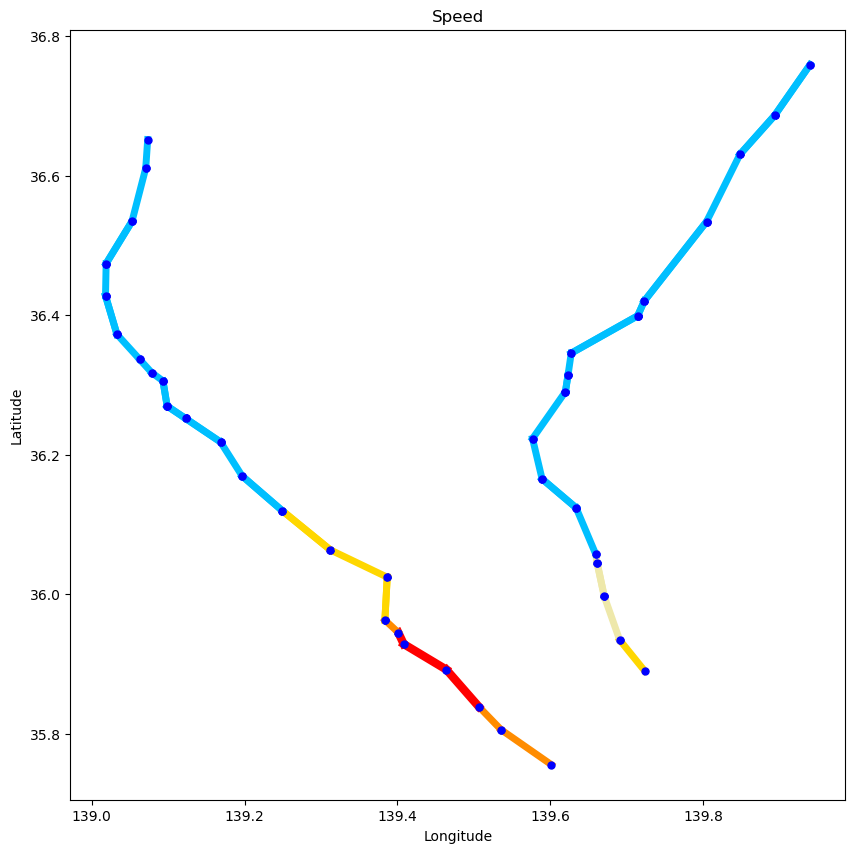

In [277]:
for index,row in df.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    speed = row['speed_block_mean']
    congestion = row['is_congestion_mean']

    if speed <= speed_series[0.05]:
        color = 'red'
        linewidth = 6
    elif (speed > speed_series[0.05]) & (speed <= speed_series[0.1]):
        color = 'darkorange'
        linewidth = 5
    elif (speed > speed_series[0.1]) & (speed <= speed_series[0.2]):
        color = 'gold'
        linewidth = 5
    elif (speed > speed_series[0.2]) & (speed <= speed_series[0.3]):
        color = 'palegoldenrod'
        linewidth = 5
    else:
        color = 'deepskyblue'
        linewidth = 5
        
    plt.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    plt.plot(start_lng, start_lat, marker='o', c='b', markersize=5) 
    plt.plot(end_lng, end_lat, marker='o', c='b',markersize=5) 

plt.rcParams['figure.figsize'] = (10,10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Speed')
#plt.legend()
plt.grid(False)
plt.show()


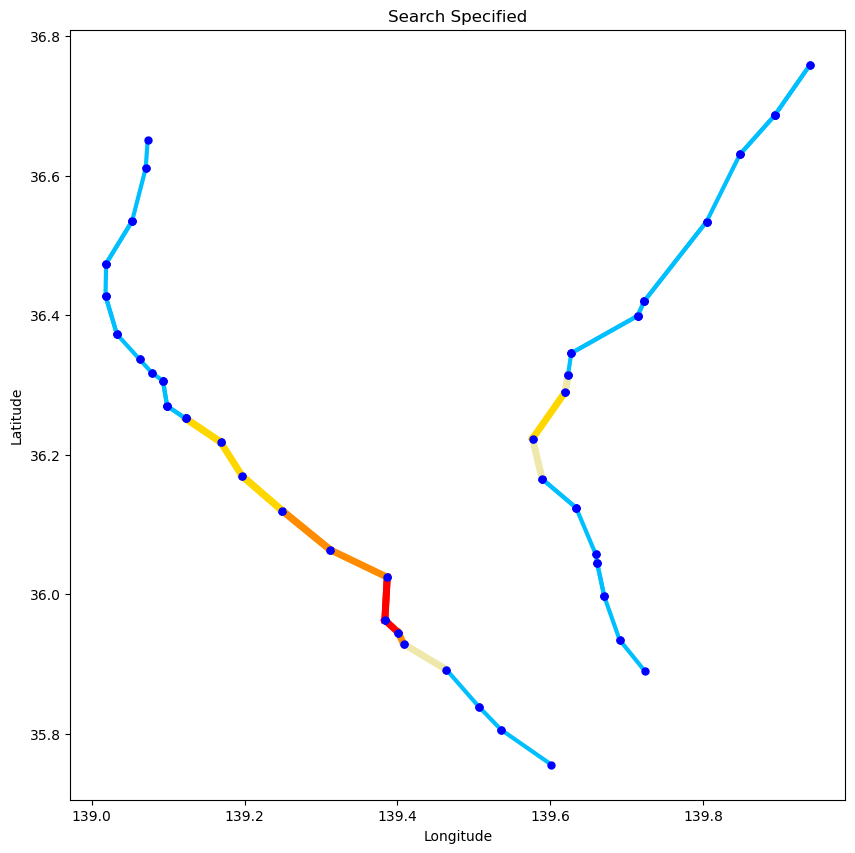

In [281]:
for index,row in df.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    search_specified = row['search_specified_block_mean']

    if search_specified >= search_specified_series[0.95]:
        color = 'red'
        linewidth = 5
    elif (search_specified >= search_specified_series[0.9]) & (search_specified < search_specified_series[0.95]):
        color = 'darkorange'
        linewidth = 5
    elif (search_specified >= search_specified_series[0.8]) & (search_specified < search_specified_series[0.9]):
        color = 'gold'
        linewidth = 5
    elif (search_specified >= search_specified_series[0.7]) & (search_specified < search_specified_series[0.8]):
        color = 'palegoldenrod'
        linewidth = 5
    else:
        color = 'deepskyblue'
        linewidth = 3
        
    plt.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    plt.plot(start_lng, start_lat, marker='o', c='b', markersize=5) 
    plt.plot(end_lng, end_lat, marker='o', c='b',markersize=5) 

plt.rcParams['figure.figsize'] = (10,10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Search Specified')
#plt.legend()
plt.grid(False)
plt.show()

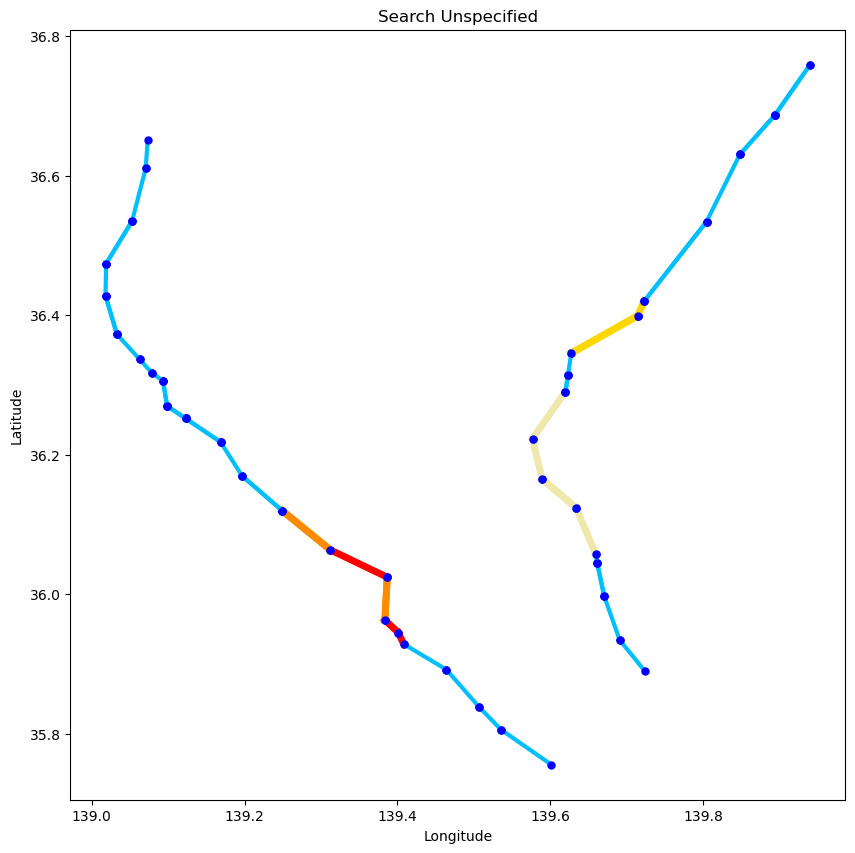

In [283]:
for index,row in df.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    search_unspecified = row['search_unspecified_block_mean']

    if search_unspecified >= search_unspecified_series[0.95]:
        color = 'red'
        linewidth = 5
    elif (search_unspecified >= search_unspecified_series[0.9]) & (search_unspecified < search_unspecified_series[0.95]):
        color = 'darkorange'
        linewidth = 5
    elif (search_unspecified >= search_unspecified_series[0.8]) & (search_unspecified < search_unspecified_series[0.9]):
        color = 'gold'
        linewidth = 5
    elif (search_unspecified >= search_unspecified_series[0.7]) & (search_unspecified < search_unspecified_series[0.8]):
        color = 'palegoldenrod'
        linewidth = 5
    else:
        color = 'deepskyblue'
        linewidth = 3
        
    plt.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    plt.plot(start_lng, start_lat, marker='o', c='b', markersize=5) 
    plt.plot(end_lng, end_lat, marker='o', c='b',markersize=5) 

plt.rcParams['figure.figsize'] = (10,10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Search Unspecified')
#plt.legend()
plt.grid(False)
plt.show()

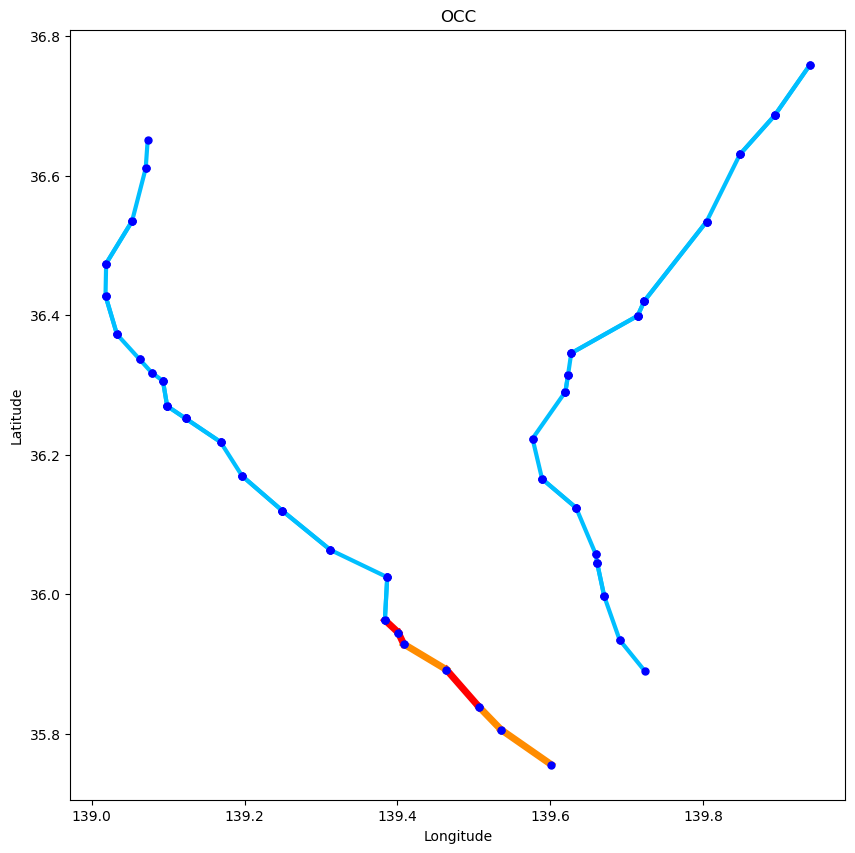

In [284]:
for index,row in df.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    OCC = row['OCC_block_mean']

    if OCC >= OCC_series[0.95]:
        color = 'red'
        linewidth = 5
    elif (OCC >= OCC_series[0.9]) & (OCC < OCC_series[0.95]):
        color = 'darkorange'
        linewidth = 5
    elif (OCC >= OCC_series[0.8]) & (search_unspecified < OCC_series[0.9]):
        color = 'gold'
        linewidth = 5
    elif (OCC >= OCC_series[0.7]) & (search_unspecified < OCC_series[0.8]):
        color = 'palegoldenrod'
        linewidth = 5        
    else:
        color = 'deepskyblue'
        linewidth = 3
        
    plt.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    plt.plot(start_lng, start_lat, marker='o', c='b', markersize=5) 
    plt.plot(end_lng, end_lat, marker='o', c='b',markersize=5) 

plt.rcParams['figure.figsize'] = (10,10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('OCC')
#plt.legend()
plt.grid(False)
plt.show()